In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/")

In [3]:
import torch
import numpy as np
import ml_collections
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from torch.utils.data import DataLoader
from diffusion_holder import DiffusionRunner
from transformers import BertConfig, BertTokenizerFast

from diffusion_holder import DiffusionRunner
from utils.util import set_seed, dict_to_cuda
from estimation_utils.util import estimate_model, reduce_metrics, gather_texts
import diffusion_utils.schedulers as schedulers

In [4]:
sns.set_theme()

# Распределение норм эмбеддингов без SC

In [6]:
from configs.config import create_config

In [7]:
config = create_config()

config.ddp = False
config.use_self_cond = False
config.checkpoints_prefix = "wikipedia--t5-bert-initial_last_"
config.validation.batch_size = 128

diffusion = DiffusionRunner(config, latent_mode=config.model.embeddings_type, eval=True)

/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-base were not used when initializing T5EncoderModel: ['decoder.block.7.layer.2.DenseReluDense.wi.weight', 'decoder.block.9.layer.1.EncDecAttention.q.weight', 'decoder.bloc

Dataset tokenization (num_proc=30):   0%|          | 0/38661 [00:00<?, ? examples/s]

In [8]:
diffusion.set_valid_data_generator()

/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
loader = iter(diffusion.valid_loader)

In [10]:
X = next(loader)
X = dict_to_cuda(X)

with torch.no_grad():
    clean_X = diffusion.encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
    cond = diffusion.encoder_cond(**{"input_ids": X["cond_ids"], "attention_mask": X["cond_mask"]})

In [11]:
_, gen_X = diffusion.generate_text(batch_size=clean_X.shape[0], cond={"cond": X["cond_ids"], "cond_mask": X["cond_mask"]})

100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


In [12]:
clean_X.shape, cond.shape

(torch.Size([128, 64, 768]), torch.Size([128, 64, 768]))

In [13]:
batch_size = clean_X.shape[0]

In [14]:
clean_X_flatten = clean_X.view(-1, clean_X.shape[-1])
h1 = torch.norm(clean_X_flatten, dim=[-1]).detach().cpu().numpy()

In [18]:
gen_X_flatten = gen_X.view(-1, gen_X.shape[-1])
h2 = torch.norm(gen_X_flatten, dim=[-1]).detach().cpu().numpy()

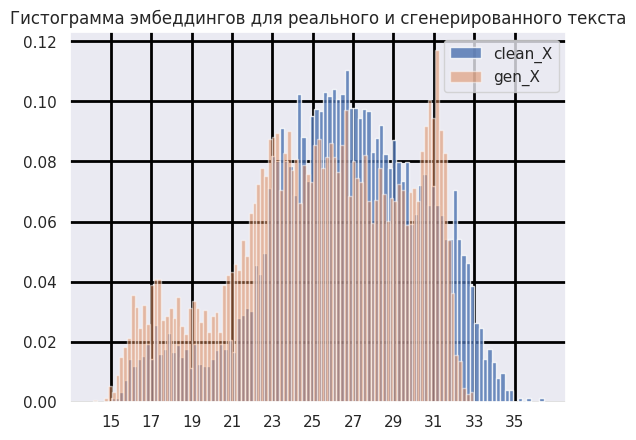

In [55]:
fig, ax = plt.subplots()

ax.set_title("Гистограмма эмбеддингов для реального и сгенерированного текста")

ax.hist(h1, label="clean_X", density=True, bins=100, alpha=0.8)
ax.hist(h2, label="gen_X", density=True, bins=100, alpha=0.5)

ax.set(xticks=np.arange(15, 37, 2))
ax.grid(color='black', linestyle='-', linewidth=2)

plt.legend()

In [33]:
def get_token(emb):
    return diffusion.tokenizer_gen.batch_decode(diffusion.pred_logits(emb.view(-1, 1, 768)).argmax(dim=-1))

## Анализ хвостов

In [35]:
from collections import Counter

In [88]:
right_tail = gen_X_flatten[h2 > 33]

In [89]:
Counter(get_token(right_tail))

Counter()

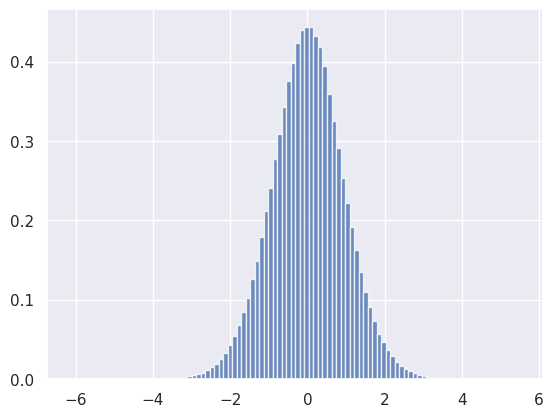

In [95]:
x = clean_X.view(-1)[:10 ** 6]
_ = plt.hist(x.cpu().numpy(), label="clean_X", density=True, bins=100, alpha=0.8)

In [96]:
torch.std(x)

tensor(0.9403, device='cuda:0')